<a href="https://colab.research.google.com/github/Davi-SC/img-RecSys/blob/main/img_rec_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configuring the environment

In [ ]:
!pip install -q torch torchvision torchaudio --upgrade
!pip install -q transformers datasets faiss-cpu pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 50.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import kagglehub
import os
import random
import shutil
from pathlib import Path
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import numpy as np
import faiss

## Download data

In [ ]:
path = kagglehub.dataset_download("fatihkgg/ecommerce-product-images-18k")

print("Path to dataset files:", path)

100%|██████████| 142M/142M [00:00<00:00, 162MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1


In [ ]:
print("Conteúdo do diretório:", os.listdir(path))
print("Conteúdo do diretório:", os.listdir(path+'/ECOMMERCE_PRODUCT_IMAGES'))

Conteúdo do diretório: ['ECOMMERCE_PRODUCT_IMAGES']
Conteúdo do diretório: ['val', 'check', 'train']


In [ ]:
dataset_path = path + '/ECOMMERCE_PRODUCT_IMAGES'
print("Estrutura completa de train:")
for root, dirs, files in os.walk(os.path.join(dataset_path, 'train')):
    print(f"{root}: {len(files)} arquivos")
print("Estrutura completa de val:")
for root, dirs, files in os.walk(os.path.join(dataset_path, 'val')):
    print(f"{root}: {len(files)} arquivos")
print("Estrutura completa de check (se aplicável):")
for root, dirs, files in os.walk(os.path.join(dataset_path, 'check')):
    print(f"{root}: {len(files)} arquivos")

Estrutura completa de train:
/root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1/ECOMMERCE_PRODUCT_IMAGES/train: 0 arquivos
/root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1/ECOMMERCE_PRODUCT_IMAGES/train/ELECTRONICS: 1353 arquivos
/root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1/ECOMMERCE_PRODUCT_IMAGES/train/HOME_KITCHEN_TOOLS: 1715 arquivos
/root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY: 3978 arquivos
/root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1/ECOMMERCE_PRODUCT_IMAGES/train/BABY_PRODUCTS: 1087 arquivos
/root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1/ECOMMERCE_PRODUCT_IMAGES/train/CLOTHING_ACCESSORIES_JEWELLERY: 1071 arquivos
/root/.cache/kagglehub/datasets/fatihkgg/ecommerce-product-images-18k/versions/1/ECOMMERCE_PRODUCT_IMAGES/train/SPORTS_OUTDOOR: 

## Filtragem para teste

In [ ]:
dataset_path = path + '/ECOMMERCE_PRODUCT_IMAGES'
test_subset = "/content/train_subset"
Path(test_subset).mkdir(exist_ok=True)


categories = ['BEAUTY_HEALTH', 'BABY_PRODUCTS', 'CLOTHING_ACCESSORIES_JEWELLERY', 'ELECTRONICS',
              'GROCERY', 'HOBBY_ARTS_STATIONERY', 'HOME_KITCHEN_TOOLS', 'PET_SUPPLIES', 'SPORTS_OUTDOOR']

for cat in categories:
    cat_path = os.path.join(dataset_path, 'train', cat)
    if os.path.exists(cat_path):
        images = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        print(f"Imagens encontradas em {cat}: {len(images)}")
        selected = random.sample(images, min(250, len(images)))
        cat_subset = os.path.join(test_subset, cat)
        Path(cat_subset).mkdir(exist_ok=True)
        for img in selected:
            source_path = os.path.join(cat_path, img)
            dest_path = os.path.join(cat_subset, img)
            shutil.copy(source_path, dest_path)
        print(f"{cat}: {len(selected)} imagens selecionadas")
    else:
        print(f"Pasta {cat} não encontrada!")

print(f"Subset criado em {test_subset}")

Imagens encontradas em BEAUTY_HEALTH: 1202
BEAUTY_HEALTH: 250 imagens selecionadas
Imagens encontradas em BABY_PRODUCTS: 1087
BABY_PRODUCTS: 250 imagens selecionadas
Imagens encontradas em CLOTHING_ACCESSORIES_JEWELLERY: 1071
CLOTHING_ACCESSORIES_JEWELLERY: 250 imagens selecionadas
Imagens encontradas em ELECTRONICS: 1353
ELECTRONICS: 250 imagens selecionadas
Imagens encontradas em GROCERY: 3978
GROCERY: 250 imagens selecionadas
Imagens encontradas em HOBBY_ARTS_STATIONERY: 1091
HOBBY_ARTS_STATIONERY: 250 imagens selecionadas
Imagens encontradas em HOME_KITCHEN_TOOLS: 1715
HOME_KITCHEN_TOOLS: 250 imagens selecionadas
Imagens encontradas em PET_SUPPLIES: 1260
PET_SUPPLIES: 250 imagens selecionadas
Imagens encontradas em SPORTS_OUTDOOR: 1235
SPORTS_OUTDOOR: 250 imagens selecionadas
Subset criado em /content/train_subset


## Extração de embeddings

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Usando dispositivo: {device}")

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.cpu().numpy().flatten()

test_subset = "/content/train_subset"
image_paths = []
for root, dirs, files in os.walk(test_subset):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(root, file))

print(f"Total de imagens para processar: {len(image_paths)}")

embeddings = []
for i, path in enumerate(image_paths):
    if i % 100 == 0:
        print(f"Processando {i}/{len(image_paths)}")
    try:
        emb = get_image_embedding(path)
        embeddings.append(emb)
    except Exception as e:
        print(f"Erro em {path}: {e}")
embeddings = np.array(embeddings)


np.save('/content/drive/MyDrive/product_embeddings.npy', embeddings)
np.save('/content/drive/MyDrive/image_paths.npy', image_paths)
print("Embeddings salvos com sucesso!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Usando dispositivo: cuda
Total de imagens para processar: 2250
Processando 0/2250
Processando 100/2250
Processando 200/2250
Processando 300/2250
Processando 400/2250
Processando 500/2250
Processando 600/2250
Processando 700/2250
Processando 800/2250
Processando 900/2250
Processando 1000/2250
Processando 1100/2250
Processando 1200/2250
Processando 1300/2250
Processando 1400/2250
Processando 1500/2250
Processando 1600/2250
Processando 1700/2250
Processando 1800/2250
Processando 1900/2250
Processando 2000/2250
Processando 2100/2250
Processando 2200/2250
Embeddings salvos com sucesso!


## Indexação e recomendação com faiss

In [ ]:
embeddings = np.load('/content/drive/MyDrive/product_embeddings.npy')
image_paths = np.load('/content/drive/MyDrive/image_paths.npy', allow_pickle=True).tolist()

dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
faiss.normalize_L2(embeddings)
index.add(embeddings)

print(f"Índice criado com {index.ntotal} vetores de {dimension} dimensões.")

Índice criado com 2250 vetores de 512 dimensões.


In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.cpu().numpy().flatten()

def recommend_similar_products(query_image_path, top_k=5):
    query_emb = get_image_embedding(query_image_path)
    query_emb = np.array([query_emb])
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)
    similar_images = [image_paths[i] for i in indices[0]]
    return similar_images, distances[0]

query_path = image_paths[0]
similar_images, similarity_scores = recommend_similar_products(query_path)
print("Imagem de entrada:", query_path)
print("Imagens recomendadas:", similar_images)
print("Scores de similaridade:", similarity_scores)

Imagem de entrada: /content/train_subset/ELECTRONICS/4399_ELECTR_train.jpeg
Imagens recomendadas: ['/content/train_subset/ELECTRONICS/4399_ELECTR_train.jpeg', '/content/train_subset/ELECTRONICS/4427_ELECTR_train.jpeg', '/content/train_subset/ELECTRONICS/4429_ELECTR_train.jpeg', '/content/train_subset/ELECTRONICS/4443_ELECTR_train.jpeg', '/content/train_subset/ELECTRONICS/4115_ELECTR_train.jpeg']
Scores de similaridade: [1.         0.94846284 0.93259853 0.93058276 0.9201983 ]


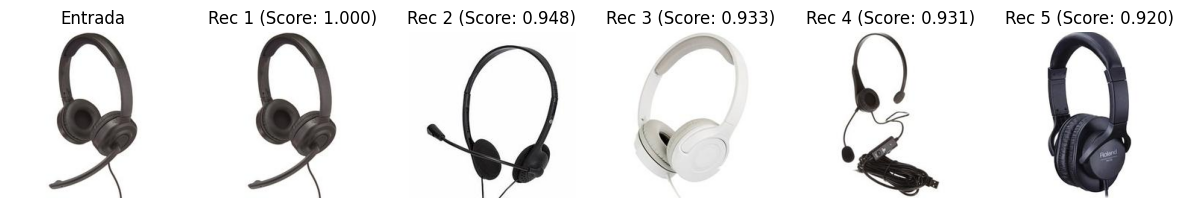

In [ ]:
import matplotlib.pyplot as plt

def display_images(query_path, similar_paths):
    images = [Image.open(query_path).convert("RGB")] + [Image.open(p).convert("RGB") for p in similar_paths]

    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
        if i == 0:
            axes[i].set_title('Entrada')
        else:
            axes[i].set_title(f'Rec {i} (Score: {similarity_scores[i-1]:.3f})')
    plt.show()

display_images(query_path, similar_images)